In [1]:
import pandas as pd
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.stats.stattools import durbin_watson

# import mvts_utils as utils
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

%load_ext autoreload
%autoreload 2

In [2]:
from utils import (
    adf_test,
    kpss_test,
    grangers_causation_matrix,
    adjust,
    cointegration_test,
    splitter,
    create_plot,
    forecast_accuracy
)


In [3]:
metrics_ = pd.DataFrame()

## Loading the Dataset

In [4]:
ts_prices_btc = pd.read_csv("Data/Time_Series/prices/bitcoin.csv",index_col='date',parse_dates=['date'])

In [5]:
crypto = 'crypto_bitcoin'
# crypto = 'crypto_ethereum'
# crypto = 'crypto_xrp'

In [6]:
for model in ['CRYPTOBERT','VADER']:
    for filetype in ['submission','comment']:
        print(f"{model}_{filetype}_sentiment")
        df = pd.read_csv(f"Data/Time_Series/{crypto}/{model}_{filetype}_sentiment.csv",index_col='posted_on',parse_dates=['posted_on'])
        # print(df.columns)
        for col in df.columns[:3]:
            # ts_prices_btc[f"{model}_{filetype}_{col}_prop"] = df[col]/df['total_posts']
            ts_prices_btc[f"{model}_{filetype}_{col}"] = df[col]
        ts_prices_btc[f"total_{filetype}"] = df['total_posts']

CRYPTOBERT_submission_sentiment
CRYPTOBERT_comment_sentiment
VADER_submission_sentiment
VADER_comment_sentiment


In [7]:
# Remove Neutral Time Series
for c in ts_prices_btc.columns:
    if 'prop' in c.lower() or 'neutral' in c.lower():
        print(f"Dropping column {c}")
        ts_prices_btc.drop(c,axis=1,inplace=True)

Dropping column CRYPTOBERT_submission_Neutral
Dropping column CRYPTOBERT_comment_Neutral
Dropping column VADER_submission_Neutral
Dropping column VADER_comment_Neutral


In [8]:
# Checking for Stationarity
for i in range(0,len(ts_prices_btc.columns)):
    # fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True)
    # ax1, ax2 = axes.flatten()
    print('Series:', ts_prices_btc.columns[i])
    # plot_acf(ts_prices_btc.iloc[1:,i], lags=60, zero=False, alpha=.05, title='Autocorrelation Plot', ax=ax1)
    # plot_pacf(ts_prices_btc.iloc[1:,i], lags=60, zero=False, alpha=.05, title='Partial Autocorrelation Plot', ax=ax2)
    # plt.show()
    adf_test(ts_prices_btc.iloc[:,i])
    kpss_test(ts_prices_btc.iloc[:,i])
    print("*"*100)

Series: price
Augmented Dicky Fuller Test
	Result: The series is non-stationary
KPSS Test
	Result: The series is non-stationary
****************************************************************************************************
Series: CRYPTOBERT_submission_Negative
Augmented Dicky Fuller Test
	Result: The series is stationary
KPSS Test
	Result: The series is non-stationary
****************************************************************************************************
Series: CRYPTOBERT_submission_Positive
Augmented Dicky Fuller Test
	Result: The series is non-stationary
KPSS Test
	Result: The series is non-stationary
****************************************************************************************************
Series: total_submission
Augmented Dicky Fuller Test
	Result: The series is non-stationary
KPSS Test
	Result: The series is non-stationary
****************************************************************************************************
Series: CRYPTOBERT_comment_

Since some of the time series are not stationary, we'll have to take first difference

In [9]:
df_first_differenced = ts_prices_btc.diff().dropna()
# Checking for Stationarity
for i in range(0,len(df_first_differenced.columns)):
    # fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True)
    # ax1, ax2 = axes.flatten()
    print('Series:', df_first_differenced.columns[i])
    # plot_acf(ts_prices_btc.iloc[1:,i], lags=60, zero=False, alpha=.05, title='Autocorrelation Plot', ax=ax1)
    # plot_pacf(ts_prices_btc.iloc[1:,i], lags=60, zero=False, alpha=.05, title='Partial Autocorrelation Plot', ax=ax2)
    # plt.show()
    adf_test(df_first_differenced.iloc[:,i])
    kpss_test(df_first_differenced.iloc[:,i])
    print("*"*100)


Series: price
Augmented Dicky Fuller Test
	Result: The series is stationary
KPSS Test
	Result: The series is stationary
****************************************************************************************************
Series: CRYPTOBERT_submission_Negative
Augmented Dicky Fuller Test
	Result: The series is stationary
KPSS Test
	Result: The series is stationary
****************************************************************************************************
Series: CRYPTOBERT_submission_Positive
Augmented Dicky Fuller Test
	Result: The series is stationary
KPSS Test
	Result: The series is stationary
****************************************************************************************************
Series: total_submission
Augmented Dicky Fuller Test
	Result: The series is stationary
KPSS Test
	Result: The series is stationary
****************************************************************************************************
Series: CRYPTOBERT_comment_Negative
Augmented Dicky Ful

### CryptoBERT model

In [10]:
df_cryptobert = ts_prices_btc[['price','CRYPTOBERT_submission_Negative','CRYPTOBERT_submission_Positive','total_submission','CRYPTOBERT_comment_Negative','CRYPTOBERT_comment_Positive','total_comment']]
df_differenced = df_first_differenced[['price','CRYPTOBERT_submission_Negative','CRYPTOBERT_submission_Positive','total_submission','CRYPTOBERT_comment_Negative','CRYPTOBERT_comment_Positive','total_comment']]

In [11]:
gc_res = grangers_causation_matrix(df_differenced, variables = df_differenced.columns, maxlag=5)    

In [12]:
def negative_yellow(val):
    color = 'grey' if val < 0.05 else ''
    return 'background-color:' + color  

def negative_bold(val):
    bold = 'bold' if val < 0.05 else ''
    return 'font-weight: %s' % bold

gc_res.style.applymap(negative_yellow).applymap(negative_bold)

,price_x,CRYPTOBERT_submission_Negative_x,CRYPTOBERT_submission_Positive_x,total_submission_x,CRYPTOBERT_comment_Negative_x,CRYPTOBERT_comment_Positive_x,total_comment_x
price_y,1.000000,0.008700,0.004500,0.006100,0.001900,0.016200,0.038800
CRYPTOBERT_submission_Negative_y,0.318300,0.998300,0.000000,0.000100,0.000600,0.000100,0.013800
CRYPTOBERT_submission_Positive_y,0.367400,0.005900,1.000000,0.016000,0.004700,0.019900,0.169600
total_submission_y,0.130300,0.388800,0.055000,1.000000,0.008600,0.003500,0.085600
CRYPTOBERT_comment_Negative_y,0.003500,0.162700,0.087200,0.073700,1.000000,0.065500,0.198100
CRYPTOBERT_comment_Positive_y,0.010200,0.045400,0.270200,0.305200,0.625500,1.000000,0.076800
total_comment_y,0.003300,0.070900,0.031500,0.060200,0.100800,0.003000,1.000000


In [13]:
cointegration_test(df_differenced)

Name                           ::  Test Stat > C(95%)    =>  Signif 
 ----------------------------------------------------------------------
price                          ::  872.57    > 111.7797  =>   True
CRYPTOBERT_submission_Negative ::  704.77    > 83.9383   =>   True
CRYPTOBERT_submission_Positive ::  547.82    > 60.0627   =>   True
total_submission               ::  398.56    > 40.1749   =>   True
CRYPTOBERT_comment_Negative    ::  259.94    > 24.2761   =>   True
CRYPTOBERT_comment_Positive    ::  149.16    > 12.3212   =>   True
total_comment                  ::  58.31     > 4.1296    =>   True


In [14]:
train_df, test_df = splitter(df_differenced)
nobs = len(test_df)

In [15]:
model = VAR(train_df)
x = model.select_order(maxlags=20)
x.summary()

,AIC,BIC,FPE,HQIC
0,46.78,46.87,2.064e+20,46.81
1,45.50,46.25*,5.780e+19,45.80
2,45.07,46.47,3.760e+19,45.63*
3,44.98,47.03,3.434e+19,45.80
4,44.85*,47.55,3.024e+19*,45.93
5,44.88,48.23,3.121e+19,46.22
6,44.88,48.88,3.166e+19,46.49
7,44.91,49.56,3.276e+19,46.77
8,44.88,50.18,3.226e+19,47.01
9,44.90,50.85,3.362e+19,47.29


In [16]:
model_fitted = model.fit(4)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 01, Apr, 2024
Time:                     00:53:21
--------------------------------------------------------------------
No. of Equations:         7.00000    BIC:                    47.9840
Nobs:                     287.000    HQIC:                   46.4330
Log likelihood:          -9161.91    FPE:                5.21384e+19
AIC:                      45.3956    Det(Omega_mle):     2.65779e+19
--------------------------------------------------------------------
Results for equation price
                                       coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------------------------
const                                  -102.241115        65.010456           -1.573           0.116
L1.price                                 -0.050601         0.062760           -0.

In [17]:
out = durbin_watson(model_fitted.resid)

for col, val in zip(df.columns, out):
    print(adjust(col), ':', round(val, 2))

Negative : 2.02
Neutral : 2.01
Positive : 2.02
total_posts : 2.06


In [18]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  #> 4

# Input data for forecasting
forecast_input = df_differenced.values[-lag_order:]
forecast_input

4


array([[-198.24,    0.  ,   16.  ,   33.  ,   36.  ,  204.  ,  392.  ],
       [-162.93,   -1.  ,  -12.  ,  -17.  ,  -25.  , -155.  , -266.  ],
       [ 105.47,    2.  ,    5.  ,   13.  ,   33.  ,  113.  ,  231.  ],
       [ -40.36,    1.  ,  -13.  ,  -26.  ,  -13.  , -101.  , -217.  ]])

In [19]:
# df = ts_prices_btc[['price','CRYPTOBERT_submission_Negative','CRYPTOBERT_submission_Positive','total_submission','CRYPTOBERT_comment_Negative','CRYPTOBERT_comment_Positive','total_comment']]
fc = model_fitted.forecast(y=forecast_input, steps=nobs)

In [20]:
df_forecast = pd.DataFrame(fc, index=df_cryptobert.index[-nobs:], columns=df_cryptobert.columns)
df_forecast

,price,CRYPTOBERT_submission_Negative,CRYPTOBERT_submission_Positive,total_submission,CRYPTOBERT_comment_Negative,CRYPTOBERT_comment_Positive,total_comment
date,,,,,,,
2022-10-20,-185.118632,-2.067558,5.255859,0.104236,-9.060007,-1.653347,0.653307
2022-10-21,160.977910,0.190717,4.475848,10.357354,13.903781,31.773584,47.400038
2022-10-22,-182.192092,0.997704,0.646916,6.989389,-2.576081,25.436585,71.926228
2022-10-23,-312.721570,-0.500209,-2.099215,-3.351397,-4.687792,-22.632895,-56.055351
2022-10-24,90.669530,-0.178950,-2.847067,-8.003730,0.364386,-19.303399,-34.727792
2022-10-25,-174.998595,0.118685,1.068633,0.792244,-1.169732,10.796613,11.549654
2022-10-26,-88.386590,0.135304,1.681861,3.095597,4.919479,8.530932,22.649782
2022-10-27,-59.652355,-0.114329,-0.497511,0.494781,-2.547107,-7.775735,-13.702846
2022-10-28,-120.887190,-0.075403,-0.585624,-0.778819,-1.492779,-4.810842,-10.539242


In [21]:
row = df_cryptobert.iloc[[0]]
row

,price,CRYPTOBERT_submission_Negative,CRYPTOBERT_submission_Positive,total_submission,CRYPTOBERT_comment_Negative,CRYPTOBERT_comment_Positive,total_comment
date,,,,,,,
2022-01-01,46319.65,4.0,41.0,81.0,85,453,1002


In [22]:
# Invert Transformation
df_result = pd.concat([df_differenced.iloc[:291],df_forecast]) 
df_result = pd.concat([row,df_result]).cumsum()

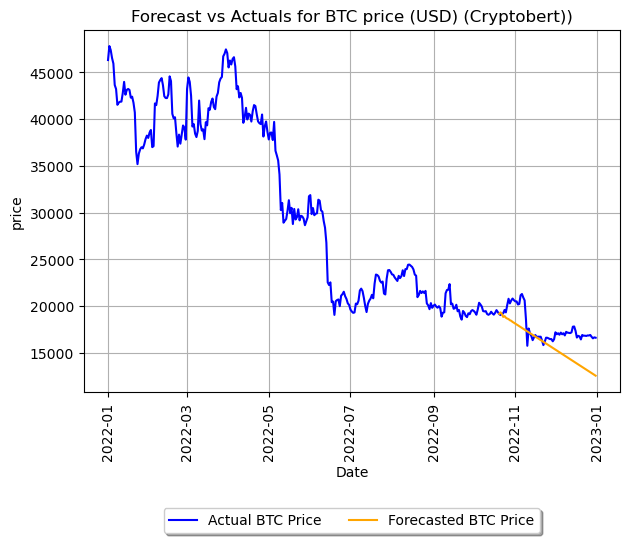

In [23]:
data_predicted = df_result['price'][-nobs:]
data_actual = df_cryptobert['price']
create_plot(data_predicted, data_actual, 'BTC', 'Cryptobert')

In [24]:
print('Forecast Accuracy of: Price')
res = forecast_accuracy(data_predicted.values, data_actual[-nobs:], rowname=['CRYPTOBERT'])
metrics_ = pd.concat([metrics_,res])
metrics_

Forecast Accuracy of: Price


,MAE,MAPE,MSE,RMSE
CRYPTOBERT,1950.33737,10.990354,5.561369e+06,2358.255398


### VADER model

In [25]:
df_vader = ts_prices_btc[['price','VADER_submission_Negative','VADER_submission_Positive','total_submission','VADER_comment_Negative','VADER_comment_Positive','total_comment']]
df_differenced = df_first_differenced[['price','VADER_submission_Negative','VADER_submission_Positive','total_submission','VADER_comment_Negative','VADER_comment_Positive','total_comment']]

In [26]:
gc_res = grangers_causation_matrix(df_differenced, variables = df_differenced.columns, maxlag=12)    

In [27]:
def negative_yellow(val):
    color = 'grey' if val < 0.05 else ''
    return 'background-color:' + color  

def negative_bold(val):
    bold = 'bold' if val < 0.05 else ''
    return 'font-weight: %s' % bold

gc_res.style.applymap(negative_yellow).applymap(negative_bold)

,price_x,VADER_submission_Negative_x,VADER_submission_Positive_x,total_submission_x,VADER_comment_Negative_x,VADER_comment_Positive_x,total_comment_x
price_y,1.000000,0.334400,0.009700,0.006100,0.111800,0.141400,0.038800
VADER_submission_Negative_y,0.000000,1.000000,0.002000,0.000000,0.000000,0.000800,0.000000
VADER_submission_Positive_y,0.001700,0.000600,1.000000,0.000000,0.002500,0.002800,0.000200
total_submission_y,0.001000,0.111500,0.000100,1.000000,0.139800,0.113900,0.061300
VADER_comment_Negative_y,0.000000,0.065200,0.000800,0.001500,1.000000,0.032800,0.008700
VADER_comment_Positive_y,0.012400,0.042200,0.039600,0.000700,0.009500,1.000000,0.033800
total_comment_y,0.001000,0.066100,0.022900,0.003500,0.066600,0.059400,1.000000


In [28]:
cointegration_test(df_differenced)

Name                           ::  Test Stat > C(95%)    =>  Signif 
 ----------------------------------------------------------------------
price                          ::  927.52    > 111.7797  =>   True
VADER_submission_Negative      ::  731.83    > 83.9383   =>   True
VADER_submission_Positive      ::  560.14    > 60.0627   =>   True
total_submission               ::  405.98    > 40.1749   =>   True
VADER_comment_Negative         ::  271.02    > 24.2761   =>   True
VADER_comment_Positive         ::  154.53    > 12.3212   =>   True
total_comment                  ::  62.02     > 4.1296    =>   True


In [29]:
train_df, test_df = splitter(df_differenced)
nobs = len(test_df)

In [30]:
model = VAR(train_df)
x = model.select_order(maxlags=20)
x.summary()

,AIC,BIC,FPE,HQIC
0,47.12,47.22,2.920e+20,47.16
1,46.19,46.93*,1.149e+20,46.49
2,45.82,47.22,7.953e+19,46.38
3,45.53,47.57,5.927e+19,46.35*
4,45.45,48.15,5.514e+19,46.53
5,45.40*,48.75,5.255e+19*,46.74
6,45.41,49.41,5.383e+19,47.02
7,45.40,50.06,5.390e+19,47.27
8,45.48,50.79,5.915e+19,47.61
9,45.51,51.46,6.170e+19,47.90


In [31]:
model_fitted = model.fit(5)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 01, Apr, 2024
Time:                     00:53:27
--------------------------------------------------------------------
No. of Equations:         7.00000    BIC:                    48.9938
Nobs:                     286.000    HQIC:                   47.0636
Log likelihood:          -9134.17    FPE:                7.63457e+19
AIC:                      45.7724    Det(Omega_mle):     3.32932e+19
--------------------------------------------------------------------
Results for equation price
                                  coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------------------
const                             -107.552928        67.123319           -1.602           0.109
L1.price                            -0.046271         0.065593           -0.705           0.481


In [32]:
out = durbin_watson(model_fitted.resid)

for col, val in zip(df.columns, out):
    print(adjust(col), ':', round(val, 2))

Negative : 2.01
Neutral : 2.0
Positive : 2.05
total_posts : 2.04


In [33]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  #> 4

# Input data for forecasting
forecast_input = df_differenced.values[-lag_order:]
forecast_input

5


array([[  57.9 ,   -5.  ,  -10.  ,  -18.  ,    6.  ,  -16.  ,  -90.  ],
       [-198.24,    3.  ,   22.  ,   33.  ,   29.  ,  107.  ,  392.  ],
       [-162.93,   -4.  ,  -12.  ,  -17.  ,  -26.  ,  -42.  , -266.  ],
       [ 105.47,    6.  ,    5.  ,   13.  ,   29.  ,   48.  ,  231.  ],
       [ -40.36,    0.  ,  -12.  ,  -26.  ,  -13.  ,  -71.  , -217.  ]])

In [34]:
# df = ts_prices_btc[['price','CRYPTOBERT_submission_Negative','CRYPTOBERT_submission_Positive','total_submission','CRYPTOBERT_comment_Negative','CRYPTOBERT_comment_Positive','total_comment']]
fc = model_fitted.forecast(y=forecast_input, steps=nobs)

In [35]:
df_forecast = pd.DataFrame(fc, index=df_vader.index[-nobs:], columns=df_vader.columns)
df_forecast

,price,VADER_submission_Negative,VADER_submission_Positive,total_submission,VADER_comment_Negative,VADER_comment_Positive,total_comment
date,,,,,,,
2022-10-20,300.811270,-2.219322,7.317009,15.171013,10.925114,13.739058,82.318454
2022-10-21,-30.709695,-0.863055,-2.860314,-7.335976,-23.706999,-17.575089,-84.467953
2022-10-22,-295.718247,0.856195,3.185340,6.343870,12.837519,27.722432,55.121690
2022-10-23,-274.042222,0.609163,-1.802074,-1.179153,-11.446295,-13.683515,-45.376093
2022-10-24,229.209198,-0.847850,1.106092,-0.325786,10.999796,8.412752,37.249072
2022-10-25,-264.152308,0.524699,-2.904766,-3.636448,-0.559451,-2.217003,13.479971
2022-10-26,103.933464,-1.068145,1.255156,-0.152044,-2.148369,-6.578880,-36.421241
2022-10-27,-185.670401,0.846124,-0.216004,2.073877,-0.256632,-0.257904,11.626193
2022-10-28,-125.601057,-0.167780,0.101368,-1.267212,-4.014667,-2.974468,-32.768939


In [36]:
row = df_vader.iloc[[0]]
row

,price,VADER_submission_Negative,VADER_submission_Positive,total_submission,VADER_comment_Negative,VADER_comment_Positive,total_comment
date,,,,,,,
2022-01-01,46319.65,10.0,45.0,81.0,86,262,1002


In [37]:
# Invert Transformation
df_result = pd.concat([df_differenced.iloc[:291],df_forecast]) 
df_result = pd.concat([row,df_result]).cumsum()

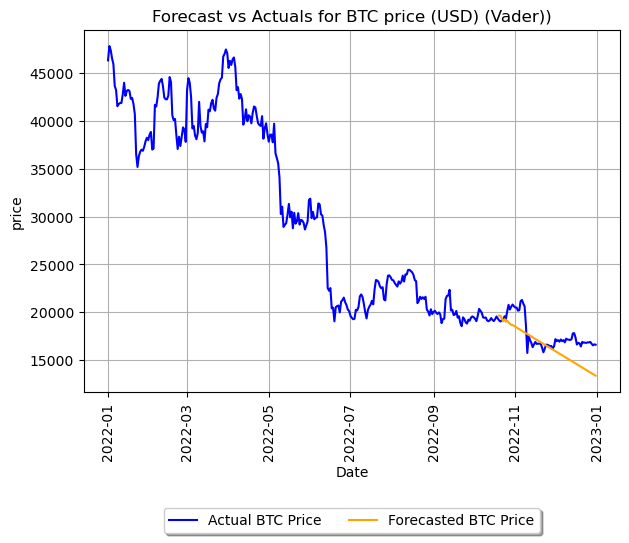

In [38]:
data_predicted = df_result['price'][-nobs:]
data_actual = df_vader['price']
create_plot(data_predicted, data_actual, 'BTC', 'Vader')

In [39]:
print('Forecast Accuracy of: Price')
# accuracy_prod = 
res = forecast_accuracy(data_predicted.values, data_actual[-nobs:],['VADER'])
metrics_ = pd.concat([metrics_, res])
metrics_

Forecast Accuracy of: Price


,MAE,MAPE,MSE,RMSE
CRYPTOBERT,1950.337370,10.990354,5.561369e+06,2358.255398
VADER,1566.489418,8.807395,3.560343e+06,1886.887077
